## 💻 UnpackAI DL201 Bootcamp - Week 2 - Concepts: Categorical Variables

### 📕 Learning Objectives

* Understand how categorical variables can be approached in datasets
* Grasp the difference encoding techniques and the ideas behind them
* See the benefits and drawbacks of different encoding techniques

### 📖 Concepts map

*  Quantitative vs. Qualitative
*  Slope: describes the relationship between x and y
    *  monotonic relationship: An always increasing relationship between x and y, not dipping up and down
*  Cardinality: The total number of categories in a column 
*  Feature Space: The total number of variables/features in a dataset

In [1]:
is_kaggle = False   # True if you are on Kaggle, False for local Windows, Linux or Mac environments.

In [2]:
if is_kaggle:
    !git clone https://github.com/unpackAI/DL201.git

In [3]:
# Imports 
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import os
import category_encoders as ce
import re

In [4]:
# path preparation
if is_kaggle:
    IMAGE_DIR = Path('/kaggle/working/DL201/img')
    DATA_DIR = Path('/kaggle/working/DL201/data')
else:
    # This section is for local execution, it is assumed that we launch the notebooks from the DL201 repository.
    DATA_DIR = Path('../data')
    IMAGE_DIR = Path('../img')
    OUTPUT_DIR = Path('../output')

# finally, check if we found the right pathes
if os.path.isdir(DATA_DIR):
    print(f'DATA_DIR is a directory, its path is {DATA_DIR}')
else:
    print("ERROR : DATA_DIR is not a directory")

if os.path.isdir(IMAGE_DIR):
    print(f'IMAGE_DIR is a directory, its path is {IMAGE_DIR}')
else:
    print("ERROR : IMAGE_DIR is not a directory")

# create an output directory if necessary
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
if os.path.isdir(OUTPUT_DIR):
    print(f'OUTPUT_DIR is a directory, its path is {OUTPUT_DIR}')
else:
    print("ERROR : OUTPUT_DIR is not a directory")

DATA_DIR is a directory, its path is ..\data
IMAGE_DIR is a directory, its path is ..\img
OUTPUT_DIR is a directory, its path is ..\output


In [5]:
### Functions

# Splitting into categorical and continious variables 

def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        #if label in L(dep_var): continue
        if ((pd.api.types.is_integer_dtype(df[label].dtype) and
            df[label].unique().shape[0] > max_card) or
            pd.api.types.is_float_dtype(df[label].dtype)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

def load_original_df(filePath):

    startups_df = pd.read_csv(filePath,encoding = 'unicode_escape')

    ### All these are specific to this dataframe
    ### Can change with custom ones if you wish

    # Data Cleansing from previous notebook
    startups_df.drop(['permalink','homepage_url'],axis=1,inplace=True)

    startups_df.columns = [col.strip() for col in list(startups_df.columns)]
    startups_df.dropna(inplace=True,axis=0) 
    startups_df['funding_total_usd'] = startups_df['funding_total_usd'].str.replace(',','')
    startups_df['funding_total_usd'] = startups_df['funding_total_usd'].str.strip()
    startups_df['funding_total_usd'] = np.where(startups_df['funding_total_usd'] == '-',0,startups_df['funding_total_usd'])
    startups_df['funding_total_usd'] = startups_df['funding_total_usd'].astype(np.int64)
    
    return startups_df

In [6]:
startupDataPath = os.path.join(DATA_DIR, 'StartUpInvestments/investments_VC.csv')
startups_df = load_original_df(startupDataPath)
startups_df.shape

(23217, 37)

### Loading the Datasets

In this example, two dataframes are used. The first is the one about startup funding, and the second is about housing.

The first one is used because it is messy and has a lot of pre-processing steps needed to make it useful.

The second is used because it is very clean, and is widely used as a benchmark to test the performance of different machine learning techniques.

In [7]:
startups_df.head()

name                               category_list  \
0             #waywire  |Entertainment|Politics|Social Media|News|   
4   -R- Ranch and Mine               |Tourism|Entertainment|Games|   
8     004 Technologies                                  |Software|   
12       1-800-DENTIST                       |Health and Wellness|   
13       1-800-DOCTORS                       |Health and Wellness|   

                   market  funding_total_usd     status country_code  \
0                   News             1750000   acquired          USA   
4                Tourism               60000  operating          USA   
8               Software                   0  operating          USA   
12   Health and Wellness                   0  operating          USA   
13   Health and Wellness             1750000  operating          USA   

   state_code                 region         city  funding_rounds  ...  \
0          NY          New York City     New York             1.0  ...   
4          TX                 Dallas   Fort Worth             2.0  ...   
8          IL  Springfield, Illinois    Champaign             1.0  ...   
12         CA            Los Angeles  Los Angeles             1.0  ...   
13         NJ                 Newark       Iselin             1.0  ...   

   secondary_market product_crowdfunding round_A  round_B round_C round_D  \
0               0.0                  0.0     0.0      0.0     0.0     0.0   
4               0.0                  0.0     0.0      0.0     0.0     0.0   
8               0.0                  0.0     0.0      0.0     0.0     0.0   
12              0.0                  0.0     0.0      0.0     0.0     0.0   
13              0.0                  0.0     0.0      0.0     0.0     0.0   

    round_E  round_F  round_G  round_H  
0       0.0      0.0      0.0      0.0  
4       0.0      0.0      0.0      0.0  
8       0.0      0.0      0.0      0.0  
12      0.0      0.0      0.0      0.0  
13      0.0      0.0      0.0      0.0  

[5 rows x 37 columns]

# Introduction
<hr style="border:4px solid gray"> </hr>

Categorical data is different than numerical data because it doesn't have the same mathematical properties of numbers.


In [8]:
cont_vars, cat_vars = cont_cat_split(startups_df)

In [9]:
cat_vars

['name',
 'category_list',
 'market',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'founded_at',
 'founded_month',
 'founded_quarter',
 'first_funding_at',
 'last_funding_at']

 As a result of not being numbers, Deep learning and AI algorithms can't accept raw categorical variables. They must be **encoded** first.

What is Encoding then? It is not to create a secret message, but to simply change information or instructions into a form that a computer can use (MacMillan Dictionary)

With categorical variables it becomes about deciding how to smartly frame a variable. 

 A lot of thought has gone into this problem over the last 100 years, so there are many ways to encode categorical variables. In this notebook, we'll go over some of the most traditional and common ways of encoding categorical variables.

* Integer Encoding
* One-Hot (Dummy) Encoding
    * Rare Encoding
* Ordinal Encoding 
* Model Specific Encodings
    * Create a relationship to the target variable
    * Utilize concept of probability
    * Add information to the model
    * But, can lead to overfitting

# Integer Encoding
<hr style="border:4px solid gray"> </hr>

For a computer, storing a string is more "expensive" than storing a number. Let's see how much memory is needed for the basic data types :

In [10]:
def get_size_of(variable):
    varSize = sys.getsizeof(variable)
    print(f'Type of variable: {type(variable)}')
    print(f'Size of variable: {varSize} bytes')

In [11]:
character = 'A'
string = 'XYZ'
integer = 1
decimal = 1.0

get_size_of(character)
get_size_of(string) 
get_size_of(integer) 
get_size_of(decimal) 

Type of variable: <class 'str'>
Size of variable: 50 bytes
Type of variable: <class 'str'>
Size of variable: 52 bytes
Type of variable: <class 'int'>
Size of variable: 28 bytes
Type of variable: <class 'float'>
Size of variable: 24 bytes


In [12]:
# Two to the 16th power is the number of information that 16 bits can store
2 ** 16

65536

With two bytes, you can hold any number from 0 to 65,535. However, there are very few words in European languages that are only two characters long.

As we can see above, one character takes 50 bytes in python, even more than the float 64 ! And a string takes 52 bytes because it contains some methods with it.

So, since computers can't read text anyways, we could imagine mapping the 65,536 most common English words to a dictionary to ***code*** each work with two bytes instead of 52.

This is the approach that a tokenizer takes to encode words on a tensor, trying to gain as much memory as possible. This saves enormous amounts of space.


### Question :
What to do if we have more than 65,535 different words on a text ?

However, it is not the end of the story. Although it is more efficient, there is one major drawback.

 These numbers still don't have any mathematical meaning. No new information gets added to the data space as a result.

However, this does not stop tree based models from using integer encoded variables.

# One Hot (Dummy) Encoding
<hr style="border:4px solid gray"> </hr>

The next method is very powerful, yet simple to implement.

Although categorical variables don't have a mathematical meaning, we can get around this limitation by treating each of the categories in a feature as a yes or no question.

In this case, yes is encoded as a 1, and no is encoded as a 0. As a result of this, we can take advantage of the special properties of the numbers zero and one.


In [13]:
0 * 100

0

The first point is that anything multiplied by zero becomes zero. This means that we can assign a parameter/coefficient to this feature because if it not present, it will drop out of the equation because anything times zero is equal to zero.

In [14]:
1 * 100

100

The second point is that anything multiplied by one remains unchanged. This means that if the catagory is present in a sample, then the parameter can have an effect on the target variable. 

In [15]:
parameter = 100 # parameter
feature_is_present = True
target = parameter * feature_is_present
print(target)

100


In Python, True has a mathematical value of 1 and false has a mathematical value of 0.

In [16]:
parameter = 100 # parameter
feature_is_present = False

target = parameter * feature_is_present
print(target)

0


### Advantages of One Hot Encoding

As a result, one hot encoding can give directionality to a variable that didn't have it before and therefore the category gains a mathematical meaning.

* This is a key advantage of One Hot Encoding

Framing it as a true or false question allows it to be included in linear models. 


### Drawbacks of One-Hot Encoding

One-hot encoding can work really well where there are just a few categories in a feature. However, when there are dozens or hundreds of  categories in a feature, it can become very messy and get out hand very quickly.

In this dataset, there are 39 features, 21,840 samples, and 851,760 data points.

In [17]:
print(startups_df.shape)
print(startups_df.shape[0] * startups_df.shape[1])

(23217, 37)
859029


In [18]:
get_size_of(startups_df)

Type of variable: <class 'pandas.core.frame.DataFrame'>
Size of variable: 24897471 bytes


However, if we were to create new features for every raw value in this category, the dataset would become enormous.

In [19]:
# This column has 666 possible raw values
startups_df['market'].nunique()

668

In [20]:
one_hot_encoded = pd.get_dummies(startups_df.market,prefix='market')

In [21]:
one_hot_df = pd.concat([startups_df, one_hot_encoded],axis = 1)

In [22]:
print(one_hot_df.shape)
print(one_hot_df.shape[0] * one_hot_df.shape[1])

(23217, 705)
16367985


In [23]:
get_size_of(one_hot_df)

Type of variable: <class 'pandas.core.frame.DataFrame'>
Size of variable: 40406427 bytes


In [24]:
del one_hot_df

Now, there are over 15 million data points in this dataframe. As we can tell, this approach can't handle diverse columns very well. 

This idea is called: Cardinality

### Cardinality

Cardinality is the total number of unique states a category can take. This variable is often represented as k, or degrees of freedom in statistics. 


Below is a snippet which counts all the unique values within a feature

In [25]:
# Cardinality of each feature
startups_df[cat_vars].nunique(axis=0).sort_values(ascending=False)[5:20]

city               2062
market              668
founded_month       392
region              286
founded_quarter     202
state_code           61
status                3
country_code          2
dtype: int64

### Rare Encoding

One way to get around this is with the rare category encoding. You can use this by setting a threshold, and assigning everything else as rare.

In [26]:
# use this line to reset everything
# and experiment with the threshold 

startups_df = load_original_df(startupDataPath)
cont_vars, cat_vars = cont_cat_split(startups_df)

In [27]:
rare_encoding_df = startups_df.copy()

In [28]:
### Rare Encoding Snippet

threshold = 0.02

df = rare_encoding_df

# we loop over all the categorical variables
features_to_rare_encode = cat_vars #list

for variable in cat_vars:
    
    # Looks for variables that account for less than the
    # Threshold percentage of the column
    counts = df[cat_vars].groupby([variable])[variable].count() / len(startups_df) 
    frequent_labels = [x for x in counts.loc[counts>threshold].index.values]
    # change the rare category names with the word rare, and thus encoding it.
    df[variable] = np.where(df[variable].isin(frequent_labels), df[variable], 'Rare')

rare_encoding_df = df.copy()
del df

In [29]:
len(rare_encoding_df.market.unique())

13

In [30]:
rare_encoding_df.market.value_counts()

Rare                     12121
 Software                 2597
 Biotechnology            1967
 Mobile                    913
 Curated Web               806
 Enterprise Software       787
 Health Care               676
 E-Commerce                652
 Hardware + Software       582
 Health and Wellness       547
 Advertising               544
 Clean Technology          537
 Games                     488
Name: market, dtype: int64

### Benefits and Drawbacks

The benefit of this is that if you are only interested in the largest number occurances, this can remove a ton of cardinality. From over 600 different values, we now have a dozen that we can focus on.

It can also handle input variables that it has never seen before, because they can easily be classified as rare.

However, the drawback is that this method is more of a hammer than a surgical knife. A lot of information gets lost in the process of rare encoding. 

# Ordinal Encoding
<hr style="border:4px solid gray"> </hr>

The halfway point between one hot encoding and integer encoding is Ordinal Encoding. If instead of just being 1 and 0, then ordinal encoding can extend numerical meaning to the categories.

For example, this can be showed for shirt sizes. In the following example, this catagorical data can be assigned a number value. 

* Extra Small = 1
* Small = 2 
* Medium = 3
* Large = 4
* Extra Large = 5




This is possible when the categories have discrete order. This often is the case when the responses are from people, rather than sensors. 

 Surveys are often structured with ordinal encoding in mind. For public opinion or customer satisfaction survey answers are often structured like this.

* Strongly Dissatisfied = -3 
* Dissatisfied = -2
* Slightly Dissatified = -1 
* No Opinion/Neutral = 0 
* Somewhat Satisfied = 1 
* Satisfied = 2
* Extremly Satisfied = 3

Let's go about finding some ordinal variables in this dataset. This is done here by using a regular expression which looks for the Condition or Quality being a part of the variable descriptor

In [31]:
house_df_path = os.path.join(DATA_DIR, 'house-prices/train.csv')
if os.path.isfile(house_df_path):
    houses_df = pd.read_csv(house_df_path, index_col=0)
    print('OK')

OK


In [32]:
housing_cont_vars, housing_cat_vars = cont_cat_split(houses_df)

Regex is a powerful tool when you can find a pattern and parse text with it.

In [33]:
pattern = re.compile(r'Qual|Cond')
housing_cat_var_series = pd.Series(housing_cat_vars)


ordinal_index = housing_cat_var_series.str.contains(pattern)

ordinal_vars = housing_cat_var_series[ordinal_index]

ordinal_vars_cardinality_counts = houses_df[ordinal_vars].nunique(axis=0).sort_values(ascending=False)
ordinal_vars_cardinality_counts

OverallQual      10
Condition1        9
OverallCond       9
Condition2        8
SaleCondition     6
ExterCond         5
GarageQual        5
GarageCond        5
ExterQual         4
BsmtQual          4
BsmtCond          4
KitchenQual       4
dtype: int64

With a simple regular expression, I now have a list of features that relates the quality and the quantity of the homes in the dataset.

In [34]:
ordinal_vars = ordinal_vars_cardinality_counts[ordinal_vars_cardinality_counts < 6 ]

In [35]:
# This removes the two that are not ordinal
# and have to do with the location of the house 
ordinal_vars

ExterCond      5
GarageQual     5
GarageCond     5
ExterQual      4
BsmtQual       4
BsmtCond       4
KitchenQual    4
dtype: int64

These features seem like promising targets for ordinal encoding. Since this dataset is very clean, it is more likely to find them in here because they were structured in such a way in advance of data collection.

In [36]:
for ordinal_var in ordinal_vars.index:
    print(ordinal_var)
    print(houses_df[ordinal_var].unique())

ExterCond
['TA' 'Gd' 'Fa' 'Po' 'Ex']
GarageQual
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageCond
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
ExterQual
['Gd' 'TA' 'Ex' 'Fa']
BsmtQual
['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond
['TA' 'Gd' nan 'Fa' 'Po']
KitchenQual
['Gd' 'TA' 'Ex' 'Fa']


In [37]:
ordinal_df = houses_df[ordinal_vars.index].copy()

In [38]:
# taken from the metadata file about
# what the abbreviations in the dataset mean
ordinal_dict = {
    'Ex': 5, #Excellent
    'Gd': 4, #Good
    'TA': 3, # Typical/Average
    'Fa': 2, # Fair
    'Po': 1, # Poor
    np.NaN: np.NaN # Not applicable 
}


for ordinal_var in ordinal_vars.index:    
    ordinal_encoded_series = ordinal_df[ordinal_var].map(ordinal_dict)
    
    # Checks to see if there are any missing values
    
    # This checks to see if the series has fully
    # Converted
    # Because if it doesn't then it means
    # Something was missed
    if not ordinal_encoded_series.dtype == 'O':
        ordinal_df[ordinal_var] = ordinal_encoded_series
    else:
        # Prints out the relevant information
        # To track down the unique variable
        print(ordinal_var)
        print(ordinal_encoded_series.value_counts())

It is good to check after applying a map on a large dataframe to see what has happened to it. Here I am interested in the 

In [39]:
ordinal_df[ordinal_vars.index].isna().sum()

ExterCond       0
GarageQual     81
GarageCond     81
ExterQual       0
BsmtQual       37
BsmtCond       37
KitchenQual     0
dtype: int64

Now that it's clear that they are encoded, I can swap them out in the original housing_df

In [40]:
houses_df[ordinal_vars.index] = ordinal_df

#### Advantages of Ordinal Encoding

* Relatively straightforward to implement.
* Can be used in linear models
* Can be used to quantify  qualitative data



#### Limitations of Ordinal Encoding

* Only works when variables have a clear ordered relationship
* Only works when varaibles have a monotonic relationship 
* Requires careful thinking of how to structure questions during data collection. 

# More Methods
<hr style="border:4px solid gray"> </hr>

There are over a dozen encoders in category encoders. However, they do have commonalities.

## Key Ideas
<hr style="border:2px solid gray"> </hr>

* Many encoding techniques create a relationship between the category and the target variable

* This relationship needs to be monotonic, which means a simple, always increasing/decreasing function with no peaks and valleys.

* The graph of stock prices has spikes in it that is non-monotonic

* Some use summary statistics to create this relationship, such as counting instances, or using the mean of each category. 

* Some some sophisticated methods use probability methods that are usually optimized for a particular model. 

The most important thing we have to understand about these advanced methods is that they introduce the risk of overfitting.

Since they try to create a relationship between the feature and the target variable, it is done under the assumption that data outside of what the model trained on is going to have that same relationship.

As a result, it is important to know what you are doing.

## Methods which use summary statistics

One way to create a monotonic relationship with this feature is to fill the values in with summary statistics on each category's group, such as the frequency of each unique state, or the mean of the target variable for each group.

### Count Encoding
<hr style="border:2px solid gray"> </hr>

Count encoding replaces the categorical feature with the number of times it appears in teh dataset. 

In [41]:
feature_cardinality = startups_df[cat_vars].nunique(axis=0).sort_values(ascending=False)

In [42]:
CountEncoder = ce.CountEncoder()
cardinality_threshold = 25
features_to_count = feature_cardinality[feature_cardinality > cardinality_threshold]
features_to_count = features_to_count[1:]

In [43]:
features_to_count

category_list       9095
first_funding_at    3318
last_funding_at     2938
founded_at          2533
city                2062
market               668
founded_month        392
region               286
founded_quarter      202
state_code            61
dtype: int64

In [44]:
count_df = startups_df[features_to_count.index].copy()
count_df = CountEncoder.fit_transform(count_df)

Now, where we once had many qualitative features, we now have numbers with a mathematical meaning, which is the number of times that the unique value appeared.

In [45]:
count_df.dtypes

category_list       int64
first_funding_at    int64
last_funding_at     int64
founded_at          int64
city                int64
market              int64
founded_month       int64
region              int64
founded_quarter     int64
state_code          int64
dtype: object

In [46]:
print(count_df.nunique(axis=0).sort_values(ascending=False))

founded_month       118
city                106
founded_at           94
market               94
region               89
founded_quarter      86
first_funding_at     71
last_funding_at      68
category_list        66
state_code           57
dtype: int64


This can be effective if there is a sweet spot in the number of variables.

However, there is an occurance, which is called "collision."

This is perfectly clear in the example of category_list.

Before, the raw column had a cardinality of over 9000, and now it has been compressed to 66. 

This may seem like an amazing thing, but what really happened is that many of the possible values ended up having the same mean.

Rather than adding new information to the model, it not only destroying information but also creates a false pattern which creates noise.

<AxesSubplot:xlabel='category_list', ylabel='Count'>

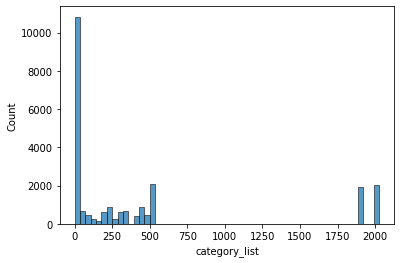

In [47]:
sns.histplot(count_df['category_list'])

Count Encoding can be useful in certain situations because it can reduce the cardinality significantly.

### Target (Mean) Encoding
<hr style="border:2px solid gray"> </hr>

Target Encoding steps further into this space. Instead of taking only information from the feature column itself, it takes information from the target variable.

This can be a good thing when the mean differs between different groups, which would create a pattern which the model can pick up. 

In [48]:
cardinality_threshold = 10

features_to_target_encode = feature_cardinality[feature_cardinality > cardinality_threshold]

# Removes the extremely cardinal features
features_to_target_encode = features_to_target_encode[2:]

In [49]:
features_to_target_encode

first_funding_at    3318
last_funding_at     2938
founded_at          2533
city                2062
market               668
founded_month        392
region               286
founded_quarter      202
state_code            61
dtype: int64

Now, these features can be encoded with the group's mean, relative to the target

In [50]:
target_encode_df = startups_df[features_to_target_encode.index].copy()
target_var = startups_df['funding_total_usd']

In [51]:
TargetEncoder = ce.TargetEncoder(cols = features_to_target_encode.index)
target_encoded_features = TargetEncoder.fit_transform(count_df,target_var)

Likewise, in this case, there are now numbers which represent the instances within the category.

In [52]:
target_encoded_features.dtypes

category_list         int64
first_funding_at    float64
last_funding_at     float64
founded_at          float64
city                float64
market              float64
founded_month       float64
region              float64
founded_quarter     float64
state_code          float64
dtype: object

This can be useful because it intorudces new information to the model.

However, it can also introduce bias because information is being leaked from the target into the dependent variables. In a scientific study this is probably unacceptable, but when modeling highly cardinal customer data, it can become useful when you know that the input data is going to be similar to the training data and you want to get higher performance. 



## A note on other advanced methods
<hr style="border:2px solid gray"> </hr>

There are plenty of more encoding methods to explore. However, these start to become very specific to whichever model they are optimized for.

Often these methods try and encode the feature as a probability that the target will be a certain value. 

If you end up in a situation where you have decided upon the model you will use and want to get more performance, then it would be  a good time to research more about which encodings are used for that particular model. 

# Wrap Up 
<hr style="border:4px solid gray"> </hr>

Category encodings attempt to deal with the problem of qualitative variables by restructuring them in a way that is either a space efficient integer, a yes/no question, an ordered set of numbers, or as a statistic about the category being encoded.

## Discussion Questions
<hr style="border:2px solid gray"> </hr>

* Why can't categorical variables be inputted into a linear model? 
* What are the benefits of Dummy Variables? What are the drawbacks?
* How can target encoding improve model performance? How can it introduce bias?
